# Проект: Маркетинг

### Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время

### Цель
Предсказать вероятность покупки в течение 90 дней

### Задачи
- изучить данные
- провести исследовательский анализ данных
- подготовить данные для моделей
- обучить разные модели (RandomForest, CatBoost) для предсказания целевого признака
- проверить качество моделей по метрике roc_auc
- оценить важность признаков

### План работ:
- открыть файл с данными и посмотреть общую информацию о данных
- провести предварительную обработку данных (работа с пропусками, выявление дубликатов, рассмотрение типов данных)
- провести исследовательский анализ данных
- создать несколько моделей и выбрать модель с лучшей метрикой качества предсказания
- оценить важность признаков и сделать выводы

## Загрузка данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

In [2]:
# Зададим константы
RANDOM_STATE = 10

In [3]:
# Загрузим данные о покупках клиентов по дням и по товарам
df_purchases = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])

In [4]:
df_purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


- **client_id** - идентификатор клиента
- **quantity** - количество единиц товара
- **price** - цена товара
- **category_ids** - идентификаторы категорий
- **date** - дата покупки
- **message_id** идентификатор сообщения из рассылки

В данных о покупках клиентов по дням и по товарам находится 202208 записей, пропусков нет

In [6]:
# Загрузим данные о рассылках, которые были отправлены клиентам из таблицы покупок
df_messages = pd.read_csv('apparel-messages.csv', parse_dates=['date'])

In [7]:
df_messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [8]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 680.4+ MB


- **bulk_campaign_id** - идентификатор рассылки
- **client_id** - идентификатор клиента
- **message_id** - идентификатор сообщения
- **event** - действие с сообщением (отправлено, открыто, покупка…)
- **channel** - канал рассылки
- **date** - дата действия
- **created_at** - дата-время полностью

In [9]:
df_messages.isnull().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

В данных о рассылках находится более 12 млн. записей, пропусков нет

In [10]:
# Загрузим данные о покупках в целевом периоде
df_target = pd.read_csv('apparel-target_binary.csv')

In [11]:
df_target.head(3)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [12]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


- **client_id** - идентификатор клиента
- **target** - клиент совершил покупку в целевом периоде

В данных о покупках в целевом периоде находится 49849 записей, пропусков нет. Есть целевой признак target

In [13]:
# Переименуем столбцы 'date', т.к. они характеризуют разные даты
df_purchases = df_purchases.rename(columns={'date': 'date_buy'})
df_messages = df_messages.rename(columns={'date': 'date_action'})

Данные успешно загружены в датафреймы, названия столбцов соответствуют форме "snake_case". Данные соответствуют описанию задачи, в данных есть целевой признак (клиент совершил покупку в целевом периоде).

### Предобработка данных

**Проверка на наличие дубликатов**

In [14]:
df_messages.duplicated().sum()

48610

In [15]:
# Удалим дубликаты
df_messages.drop_duplicates(inplace=True)
df_messages.duplicated().sum()

0

In [16]:
df_purchases.duplicated().sum()

73020

In [17]:
# Удалим дубликаты
df_purchases.drop_duplicates(inplace=True)
df_purchases.duplicated().sum()

0

In [18]:
df_target.duplicated().sum()

0

**Проверка на наличие дубликатов в столбцах**

In [19]:
# Преобразуем тип данных
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [20]:
df_messages['message_id'].duplicated().sum()

3629521

Есть много записей с повторяющимся message_id. Оставим только те message_id, у которых крайние даты и время операции

In [21]:
df_messages = df_messages.pivot_table(
    index='message_id', values='created_at', aggfunc='max').reset_index().merge(
        df_messages, on=['message_id', 'created_at'], how='left')

In [22]:
# Округлим до даты
df_messages['created_at'] = pd.DatetimeIndex(df_messages['created_at']).date

In [23]:
# Поищем записи, в которых столбец 'date' не равен столбцу 'created_at'
df_messages.query('date_action != created_at')

,message_id,created_at,bulk_campaign_id,client_id,event,channel,date_action


Таких столбцов нет, поэтому удалим столбец 'created_at'

In [24]:
df_messages.drop(columns=['created_at'], inplace=True)

In [25]:
df_messages.duplicated().sum()

0

Похоже, что столбец message_id содержит значения столбцов bulk_campaign_id и client_id. Проверим это

In [26]:
# Разделим message_id. В качестве разделителя используем символ "-"
new_df = df_messages['message_id'].str.split('-', expand=True)

In [27]:
new_df[0] = new_df[0].astype('int64')
new_df[1] = new_df[1].astype('int64')

In [28]:
# Посчитаем различия
(new_df[0] != df_messages['client_id']).sum()

0

In [29]:
(new_df[1] != df_messages['bulk_campaign_id']).sum()

0

Таких отличий нет. Значит столбцы bulk_campaign_id и client_id дублируют столбец message_id

In [30]:
df_messages.head(3)

,message_id,bulk_campaign_id,client_id,event,channel,date_action
0,1515915625468060902-10022-63e5ededd911f,10022,1515915625468060902,send,email,2023-02-10
1,1515915625468060902-10218-63ef56ed94656,10218,1515915625468060902,send,email,2023-02-17
2,1515915625468060902-10289-63f35a8a9ff35,10289,1515915625468060902,send,email,2023-02-20


In [31]:
df_purchases['category_ids'].nunique()

933

**Разделим category_ids на несколько колонок**

In [32]:
# Посчитаем сколько раз встречается каждая категория в наборе данных
category_dict = {}
for cat_ids in df_purchases['category_ids']:
    for cat_id in ast.literal_eval(cat_ids):
        if cat_id in category_dict:
            category_dict[cat_id] += 1
        else:
            category_dict[cat_id] = 1

In [33]:
len(category_dict)

1152

In [35]:
for name_category in category_dict.keys():
    if name_category is None:
        continue
    if category_dict[name_category] > 50: # Исключаем редковстречающиеся категории
        df_purchases['cat_'+name_category] = df_purchases['category_ids'].str.contains("'" + name_category + "'")
        df_purchases['cat_'+name_category] = df_purchases['cat_'+name_category].apply(lambda x: 1 if x else 0)

In [36]:
df_purchases.head(3)

,client_id,quantity,price,category_ids,date_buy,message_id,cat_4,cat_28,cat_57,cat_431,...,cat_6064,cat_6047,cat_6068,cat_5746,cat_6075,cat_1381,cat_6245,cat_6079,cat_6243,cat_6244
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_purchases.drop(columns=['category_ids'], inplace=True)

In [38]:
# Удалим дубликаты
df_purchases.drop_duplicates(inplace=True)
df_purchases.duplicated().sum()

0

In [39]:
df_purchases.head(3)

,client_id,quantity,price,date_buy,message_id,cat_4,cat_28,cat_57,cat_431,cat_244,...,cat_6064,cat_6047,cat_6068,cat_5746,cat_6075,cat_1381,cat_6245,cat_6079,cat_6243,cat_6244
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Провели предобработку данных (удалили дубликаты и разделили category_ids на подкатегории)

### Исследовательский анализ данных

#### Статистический анализ признаков

In [40]:
# создадим функцию для построения плотности частоты, диаграммы размаха и вывода описательной статистики для признаков 
def build_graph(num_feature, name):
    plt.figure(figsize=(7,7))
    
    plt.subplot(2, 1, 1)
    num_feature.plot.kde(grid=True)
    plt.title("Гистограмма плотности частоты")
    plt.xlabel(name)
    plt.ylabel('Плотность частоты')
   
    plt.subplot(2, 1, 2)
    sns.boxplot(x=num_feature)
    plt.title("Диаграмма размаха")
    plt.xlabel(name)
    plt.tight_layout(pad=3.0)
    
    plt.show()
    
    print(pd.concat([
         num_feature.describe(), 
    ], axis=1)) 

##### Данные о покупках в целевом периоде

In [41]:
df_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

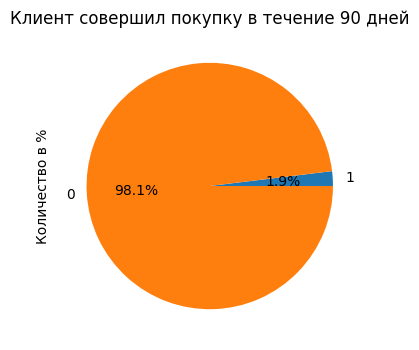

In [42]:
plt.figure(figsize=(4,4))
df_target['target'].value_counts(ascending=True).plot(kind='pie', autopct='%.1f%%')
plt.title("Клиент совершил покупку в течение 90 дней")
plt.ylabel('Количество в %')
plt.show()

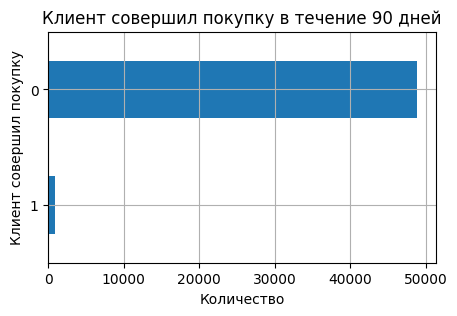

In [43]:
plt.figure(figsize=(5,3))
df_target['target'].value_counts(ascending=True).plot(kind='barh', grid=True)
plt.title("Клиент совершил покупку в течение 90 дней")
plt.xlabel('Количество')
plt.ylabel('Клиент совершил покупку')
plt.show()

В наборе данных есть дисбаланс классов. Клиентов, которые совершили покупки в течение 90 дней, значительно меньше, чем клиентов, которые не совершили покупки.

In [44]:
df_target['client_id'].nunique()

49849

##### Данные о покупках клиентов по дням и по товарам

In [45]:
df_purchases['client_id'].nunique()

49849

In [46]:
# Проверим сколько клиентов нет из целевого набора
pur_client_id = df_purchases['client_id'].unique()
df_target[~df_target['client_id'].isin(pur_client_id)].shape[0]

0

Количество уникальных клиентов в наборе данных совпадают с количеством уникальных клиентов в данных о покупках в целевом периоде и в наборе данных о покупках есть данные обо всех клиентах из целевого набора

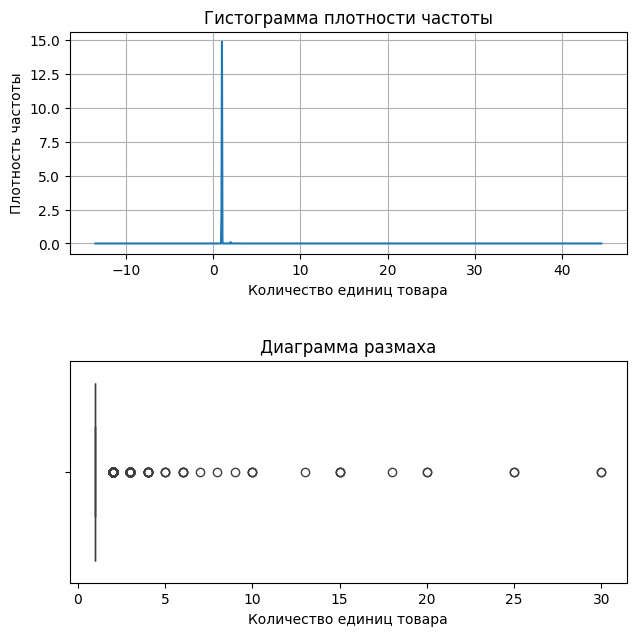

            quantity
count  129100.000000
mean        1.009427
std         0.220407
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        30.000000


In [47]:
build_graph(df_purchases['quantity'], 'Количество единиц товара')

Аномалий нет. Такое количество единиц товара возможно

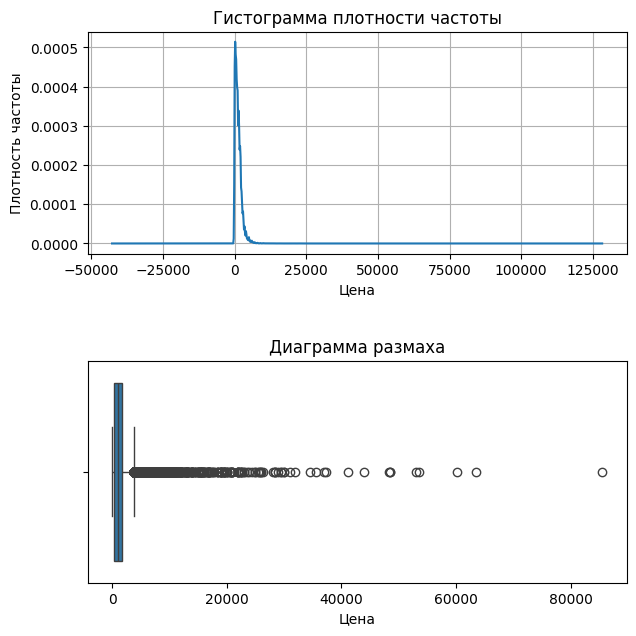

               price
count  129100.000000
mean     1265.014934
std      1375.107807
min         1.000000
25%       399.000000
50%       999.000000
75%      1750.000000
max     85499.000000


In [48]:
build_graph(df_purchases['price'], 'Цена')

Аномалий нет. Такие цены возможны

In [49]:
df_purchases['date_buy'].nunique()

642

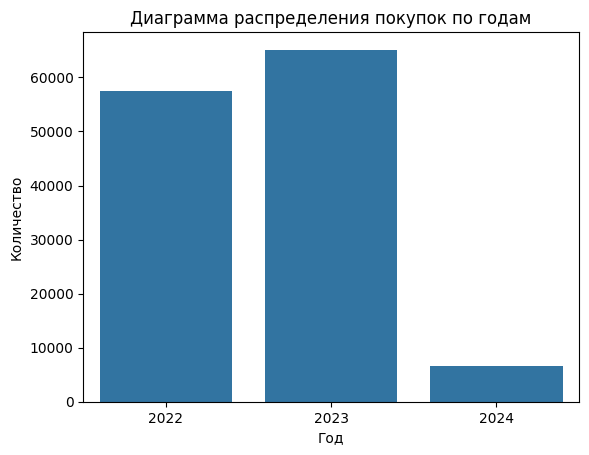

In [50]:
sns.countplot(x=pd.DatetimeIndex(df_purchases['date_buy']).year)
plt.title("Диаграмма распределения покупок по годам")
plt.xlabel("Год")
plt.ylabel('Количество')
plt.show()

Больше всего покупок было в 2023 году. Данные за 2024 год представлены за неполный год.

In [51]:
df_purchases['message_id'].nunique()

50204

##### Данные о рассылках

In [52]:
df_messages['bulk_campaign_id'].nunique()

2709

In [53]:
df_messages['client_id'].nunique()

53329

In [54]:
# Проверим сколько клиентов нет из целевого набора
mess_client_id = df_messages['client_id'].unique()
df_target[~df_target['client_id'].isin(mess_client_id)].shape[0]

7867

Количество уникальных клиентов в наборе данных больше, чем количество уникальных клиентов в данных о покупках в целевом периоде, но в наборе данных о рассылках нет данных о 7867 клиентах из целевого набора данных, т.е. им рассылок не было или данные о рассылках этим клиентам потерялись

In [55]:
df_messages['event'].value_counts()

event
send           6050134
open           2700747
click           287870
purchase         42739
hard_bounce      18635
soft_bounce       9918
unsubscribe       1735
hbq_spam           823
complain           483
subscribe           26
close                1
Name: count, dtype: int64

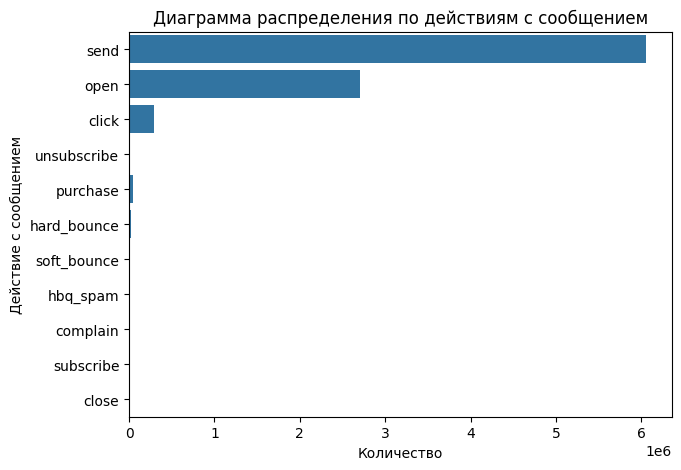

In [56]:
plt.figure(figsize=(7,5))
sns.countplot(y=df_messages['event'])
plt.title("Диаграмма распределения по действиям с сообщением")
plt.ylabel("Действие с сообщением")
plt.xlabel('Количество')
plt.show()

Самое частое действие с сообщением это send (отправлено)

In [57]:
df_messages.duplicated().sum()

0

In [58]:
df_messages['channel'].value_counts()

channel
mobile_push    5146976
email          3966135
Name: count, dtype: int64

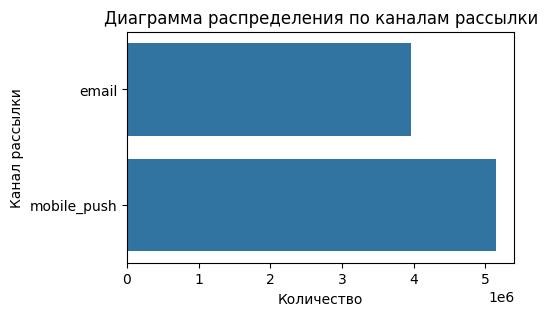

In [59]:
plt.figure(figsize=(5,3))
sns.countplot(y=df_messages['channel'])
plt.title("Диаграмма распределения по каналам рассылки")
plt.ylabel("Канал рассылки")
plt.xlabel('Количество')
plt.show()

Самым частым каналом рекламной рассылки является mobile_push (мобильные уведомления)

In [60]:
df_messages['date_action'].nunique()

638

In [61]:
print("Диапазон дат:")
print(df_messages['date_action'].min())
print(df_messages['date_action'].max())

Диапазон дат:
2022-05-19 00:00:00
2024-02-15 00:00:00


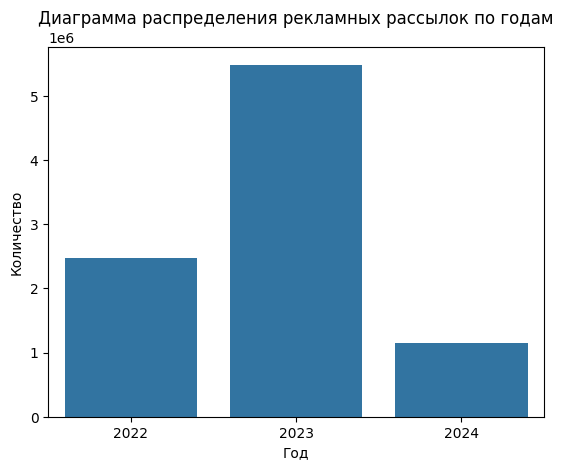

In [62]:
sns.countplot(x=pd.DatetimeIndex(df_messages['date_action']).year)
plt.title("Диаграмма распределения рекламных рассылок по годам")
plt.xlabel("Год")
plt.ylabel('Количество')
plt.show()

Больше всего рекламных рассылок было в 2023 году. Данные за 2024 представлены до 15.02.2024

In [63]:
df_purchases['client_id'].nunique()

49849

In [64]:
df_purchases.shape

(129100, 536)

В наборе данных количество записей больше чем количество клиентов, поэтому проведем агрегацию данных по клиенту

In [65]:
# Выберем колонки, по которым будем применять агрегирующую функцию
columns = list(df_purchases.columns)
columns.remove('client_id')
columns.remove('date_buy')
columns.remove('message_id')
columns.remove('price')

In [66]:
# Проведем разную агрегацую для разных колонок и объединим результат
df_purch_agg = pd.concat(
    [
        df_purchases.pivot_table(index='client_id', values='date_buy', aggfunc='max'), 
        df_purchases.pivot_table(index='client_id', values=columns, aggfunc='sum'),
        df_purchases.pivot_table(index='client_id', values='price', aggfunc='mean'),
    ], 
    axis=1)

In [67]:
df_purch_agg.reset_index(inplace=True)

In [68]:
df_purch_agg.head(3)

,client_id,date_buy,cat_1006,cat_1009,cat_1010,cat_1014,cat_1037,cat_104,cat_107,cat_108,...,cat_905,cat_928,cat_934,cat_936,cat_938,cat_939,cat_966,cat_991,quantity,price
0,1515915625468060902,2022-05-27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,959.000000
1,1515915625468061003,2023-01-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,2355.833333
2,1515915625468061099,2022-05-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,299.000000


In [69]:
df_purch_agg.shape

(49849, 535)

In [70]:
# Создадим новый признак - разница в днях от максимальной даты
df_purch_agg['num_days'] = (df_purch_agg['date_buy'].max() - df_purch_agg['date_buy']).dt.days

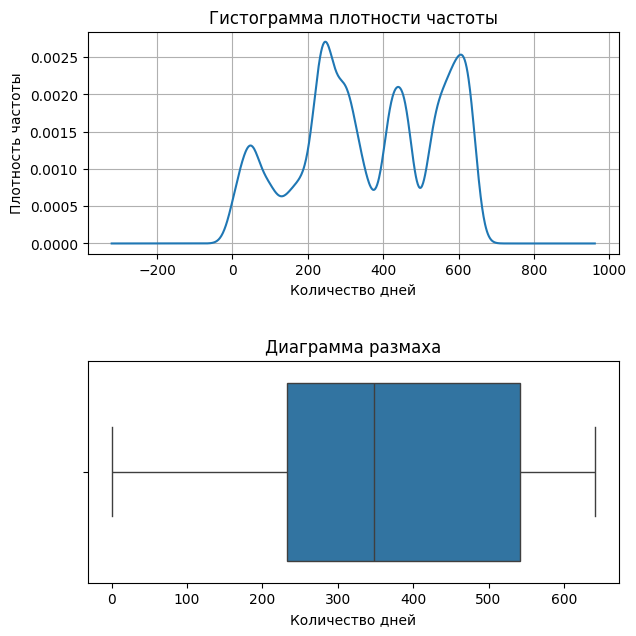

           num_days
count  49849.000000
mean     361.931593
std      185.301691
min        0.000000
25%      233.000000
50%      348.000000
75%      542.000000
max      641.000000


In [71]:
build_graph(df_purch_agg['num_days'], 'Количество дней')

In [72]:
# Для каждого типа события создадим отдельный столбец
events = df_messages['event'].unique()
for e in events:
    df_messages[e] = df_messages['event'].apply(lambda x: 1 if x == e else 0)

In [73]:
# Для каждого типа канала создадим отдельный столбец
channels = df_messages['channel'].unique()
for c in channels:
    df_messages[c] = df_messages['channel'].apply(lambda x: 1 if x == c else 0)

In [74]:
df_messages.head(3)

,message_id,bulk_campaign_id,client_id,event,channel,date_action,send,open,click,unsubscribe,purchase,hard_bounce,soft_bounce,hbq_spam,complain,subscribe,close,email,mobile_push
0,1515915625468060902-10022-63e5ededd911f,10022,1515915625468060902,send,email,2023-02-10,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1515915625468060902-10218-63ef56ed94656,10218,1515915625468060902,send,email,2023-02-17,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1515915625468060902-10289-63f35a8a9ff35,10289,1515915625468060902,send,email,2023-02-20,1,0,0,0,0,0,0,0,0,0,0,1,0


In [75]:
# Выберем колонки, по которым будем применять агрегирующую функцию
columns = list(df_messages.columns)
columns.remove('message_id')
columns.remove('bulk_campaign_id')
columns.remove('event')
columns.remove('channel')
columns.remove('date_action')
columns.remove('client_id')

In [76]:
df_mess_agg = df_messages.pivot_table(index='client_id', values=columns, aggfunc='sum').reset_index()

In [77]:
df_mess_agg.head(3)

,client_id,click,close,complain,email,hard_bounce,hbq_spam,mobile_push,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,4,0,0,127,0,0,0,27,1,94,0,0,1
1,1515915625468061003,3,0,0,154,0,0,0,1,1,149,0,0,0
2,1515915625468061099,6,0,0,158,2,0,61,44,0,167,0,0,0


In [78]:
df_mess_agg.shape

(53329, 14)

**Корреляционный анализ данных**

Будем использовать корреляцию Спирмена, т.к. в данных есть ненормальное распределение и выбросы

**Корреляционный анализ агрегированных данных рассылки**

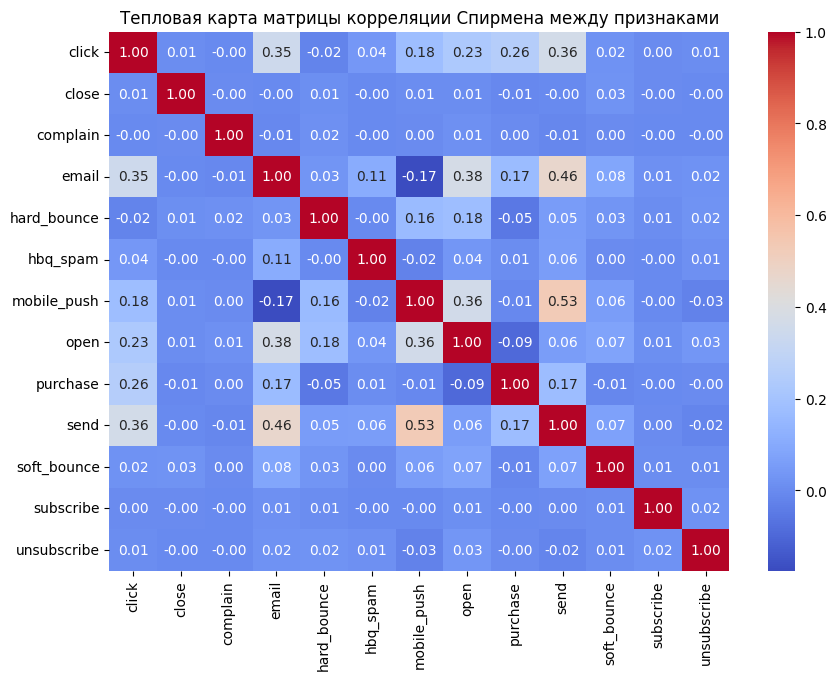

In [79]:
plt.figure(figsize=(10,7))
sns.heatmap(
    df_mess_agg.drop(columns='client_id').corr(method='spearman'), 
    cmap='coolwarm', 
    annot=True,
    fmt='.2f').set(title="Тепловая карта матрицы корреляции Спирмена между признаками")
plt.show()

Между признаками нет мультиколлинеарности

**Корреляционный анализ агрегированных данных о покупках клиентов**

In [80]:
corr_matrix = df_purch_agg.corr(method='spearman')

Проведем поиск мультиколленеарности между признаками. Если между признаками будет найдена мультиколлинеарность, то удалим один из них

In [81]:
del_feat = set() # Набор признаков для удаления
for element_1 in corr_matrix:
    if element_1 in del_feat:
        continue
    for element_2 in corr_matrix:
        if element_2 in del_feat:
            continue
        if element_1 != element_2:
            if corr_matrix[element_1][element_2] >= 0.9:
                del_feat.add(element_1)

In [82]:
len(del_feat)

103

In [83]:
df_purch_agg.drop(columns=del_feat, inplace=True)

In [84]:
df_purch_agg.shape

(49849, 433)

### Объединим датафреймы

In [85]:
df_target = df_target.merge(df_mess_agg, on='client_id', how='left')

In [86]:
df_target.isnull().sum()

client_id         0
target            0
click          7867
close          7867
complain       7867
email          7867
hard_bounce    7867
hbq_spam       7867
mobile_push    7867
open           7867
purchase       7867
send           7867
soft_bounce    7867
subscribe      7867
unsubscribe    7867
dtype: int64

Пропуски у тех клиентов, для которых не было рассылок. Заменим пропуски нулями.

In [87]:
df_target.fillna(value=0, inplace=True)

In [88]:
df_target = df_target.merge(df_purch_agg, on='client_id', how='left')

In [89]:
df_target.head(3)

,client_id,target,click,close,complain,email,hard_bounce,hbq_spam,mobile_push,open,...,cat_928,cat_934,cat_936,cat_938,cat_939,cat_966,cat_991,quantity,price,num_days
0,1515915625468060902,0,4.0,0.0,0.0,127.0,0.0,0.0,0.0,27.0,...,0,0,0,0,0,0,0,5,959.000000,630
1,1515915625468061003,1,3.0,0.0,0.0,154.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,6,2355.833333,408
2,1515915625468061099,0,6.0,0.0,0.0,158.0,2.0,0.0,61.0,44.0,...,0,0,0,0,0,0,0,1,299.000000,640


In [90]:
df_target.shape

(49849, 447)

### Обучение моделей

#### Подготовка данных для обучения

In [91]:
# Выберем все числовые признаки кроме 'client_id', 'target'
num_columns = list(df_target.drop(columns=['client_id', 'target']).select_dtypes(include='number'))

In [92]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [93]:
X = df_target[num_columns]
y = df_target['target']

In [94]:
X.head(3)

,click,close,complain,email,hard_bounce,hbq_spam,mobile_push,open,purchase,send,...,cat_928,cat_934,cat_936,cat_938,cat_939,cat_966,cat_991,quantity,price,num_days
0,4.0,0.0,0.0,127.0,0.0,0.0,0.0,27.0,1.0,94.0,...,0,0,0,0,0,0,0,5,959.000000,630
1,3.0,0.0,0.0,154.0,0.0,0.0,0.0,1.0,1.0,149.0,...,0,0,0,0,0,0,0,6,2355.833333,408
2,6.0,0.0,0.0,158.0,2.0,0.0,61.0,44.0,0.0,167.0,...,0,0,0,0,0,0,0,1,299.000000,640


In [95]:
X.shape

(49849, 444)

In [96]:
y.shape

(49849,)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

In [98]:
print(X_train.shape)
X_test.shape

(34894, 444)


(14955, 444)

In [99]:
X_train_prep = data_preprocessor.fit_transform(X_train)

In [100]:
X_test_prep = data_preprocessor.transform(X_test)

#### Обучение модели RandomForest

In [101]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

In [102]:
# Создадим словарь с гиперпараметрами:
rfc_parameters = {
    'n_estimators': [200, 300],
    'max_depth': range(15, 20)
}

In [103]:
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5 и n_jobs=-1.
rfc_gs = GridSearchCV(model_rfc, rfc_parameters, cv=5, n_jobs=-1, scoring='roc_auc')

In [104]:
# Запустим поиск гиперпараметров
%time rfc_gs.fit(X_train_prep, y_train)

Wall time: 13min 43s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': range(15, 20),
                         'n_estimators': [200, 300]},
             scoring='roc_auc')

In [105]:
print("Лучшие гиперпараметры", rfc_gs.best_params_)
print("Лучшая метрика по кросс-вадидации", rfc_gs.best_score_)

Лучшие гиперпараметры {'max_depth': 19, 'n_estimators': 300}
Лучшая метрика по кросс-вадидации 0.7417674032516842


#### Обучение модели CatBoost

In [106]:
cb_model = CatBoostClassifier(
            random_seed = RANDOM_STATE,
            verbose=False
)

In [107]:
# Создадим словарь с гиперпараметрами:
cb_parameters = {
    'iterations': [500, 1000],
    'learning_rate': [0.02, 0.05],
    'depth': [8, 10]
}

In [108]:
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5 и n_jobs=-1.
cb_gs = GridSearchCV(cb_model, cb_parameters, cv=5, n_jobs=-1, scoring='roc_auc')

In [109]:
# Запустим поиск гиперпараметров
%time cb_gs.fit(X_train_prep, y_train)

Wall time: 38min 31s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000025229427340>,
             n_jobs=-1,
             param_grid={'depth': [8, 10], 'iterations': [500, 1000],
                         'learning_rate': [0.02, 0.05]},
             scoring='roc_auc')

In [110]:
print("Лучшие гиперпараметры", cb_gs.best_params_)
print("Лучшая метрика по кросс-вадидации", cb_gs.best_score_)

Лучшие гиперпараметры {'depth': 8, 'iterations': 1000, 'learning_rate': 0.02}
Лучшая метрика по кросс-вадидации 0.75749169587834


#### Проверка качества предсказания лучшей модели на тестовой выборке

In [111]:
model = CatBoostClassifier(**cb_gs.best_params_, random_state=RANDOM_STATE, verbose=False)
%time model.fit(X_train_prep, y_train)

Wall time: 40.4 s


In [112]:
y_test_pred = model.predict_proba(X_test_prep)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test.to_list(), y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.7132560434232555


### Анализ важности признаков

#### Оценим важность признаков для лучшей модели

In [113]:
feature_importance = model.get_feature_importance()

In [114]:
df_feat = pd.DataFrame([X.columns, feature_importance]).T.rename(columns={0: 'feature', 1: 'importance'})

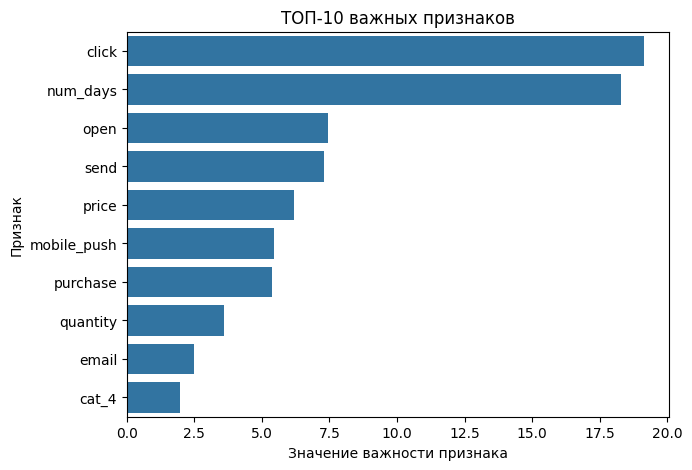

In [115]:
plt.figure(figsize=(7, 5))
sns.barplot(data=df_feat.sort_values(by='importance', ascending=False).head(10), x='importance', y='feature')
plt.xlabel('Значение важности признака')
plt.ylabel('Признак')
plt.title('ТОП-10 важных признаков')
plt.show()

Наиболее важными признаками являются click (клик на рекламное сообщение), num_days (количество дней прошедших после покупки), open (открыто рекламное сообщение), send (отправлено рекламное сообщение) и price (цена купленного товара)

#### Оценим и построим важность признаков с помощью метода SHAP

In [116]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_prep)
shap_values.feature_names=X.columns

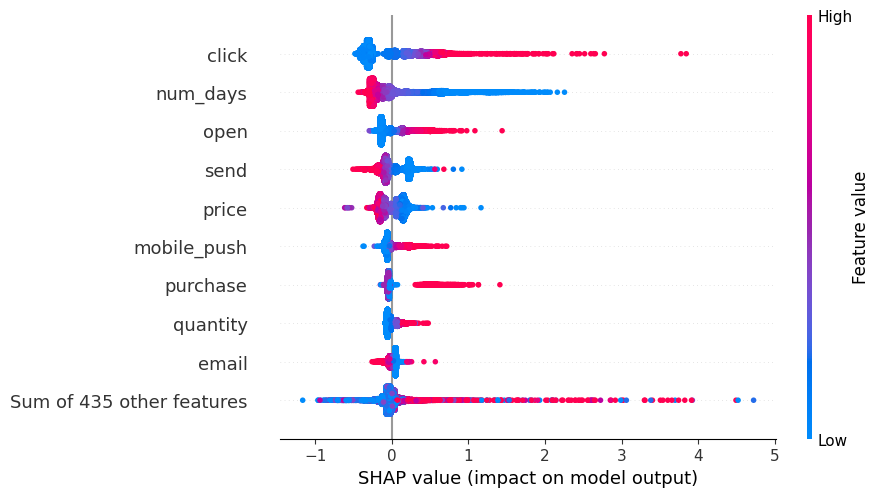

In [117]:
shap.plots.beeswarm(shap_values)

Чем больше количество кликов на рекламные сообщения (или открытий рекламных сообщений), тем больше вероятность покупки в течение 90 дней. Если клиент не кликает на рекламные сообщения (или не открывает рекламные сообщения), то модель уверенее предсказывает, что клиент не будет совершать покупки в течение 90 дней.

Чем больше прошло количество дней после последней покупки клиентом, тем больше вероятность покупки в течение 90 дней. Чем меньше дней прошло с даты последней покупки, тем модель уверенее предсказывает, что клиент не будет совершать покупки в течение 90 дней.

Чем больше мобильных уведомлений, тем больше вероятность покупки в течение 90 дней

**Общий вывод**

Для достижения цели проекта было выполнено: 
- загрузили данные в датафреймы. Данные соответствуют описанию задачи, в данных есть целевой признак (клиент совершил покупку в целевом периоде);
- провели предварительную обработку данных. Удалили дубликаты и разделили category_ids на подкатегории;
- провели исследовательский анализ данных. В наборе данных есть дисбаланс классов. Клиентов, которые совершили покупки в течение 90 дней, значительно меньше, чем клиентов, которые не совершили покупки. По результатам корреляционного анализа была выявлена мультиколлинеарность между подкатегориями товара;
- провели объединение датафреймов, выбрали и подготовили данные для обучения моделей
- провели обучение моделей RandomForest и CatBoost с подборкой гиперпараметров для предсказания целевого признака – клиент совершил покупку в целевом периоде;
- провели анализ моделей сравнив их качество предсказания по метрике ROC_AUC;
- у модели CatBoost лучше качество предсказания по кросс-валидации, чем у модели RandomForest. Проверили качества предсказания лучшей модели (CatBoost) на тестовой выборке. Метрика roc_auc получилась равной 0.71
- провели анализ важности признаков. Вероятность покупки в течение 90 дней выше, если больше количество кликов на рекламные сообщения (или открытий рекламных сообщений) и больше прошло количество дней после последней покупки клиентом. Кроме того, больше вероятность покупки если клиенту отправлены рекламные сообщения через мобильные уведомления, а не по электронной почте.